In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:0


In [2]:
from bliss import sleep

In [3]:
import sys
sys.path.append('./starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [7]:
model_filename = './fits/starnet'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [8]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [9]:
border_padding = sleep_net.image_encoder.border_padding

# Load m2 data

In [10]:
run = 2583
camcol = 2
field = 136

sdss_frame, hubble_catalog, sdss_background, sdss_data, wcs = \
    m2_data.load_m2_data()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ./hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [17]:
hubble_catalog['locs'].shape

torch.Size([94296, 2])

In [11]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

In [12]:
# filter by bright stars 
fmin = 1000.
hubble_catalog = plotting.filter_catalog(hubble_catalog,
                                         hubble_catalog['fluxes'][:, 0] > fmin)

### restrict to the chunk containing m2

In [13]:
x0 = 680
x1 = sleep_net.image_encoder.border_padding
chunk_slen = 500

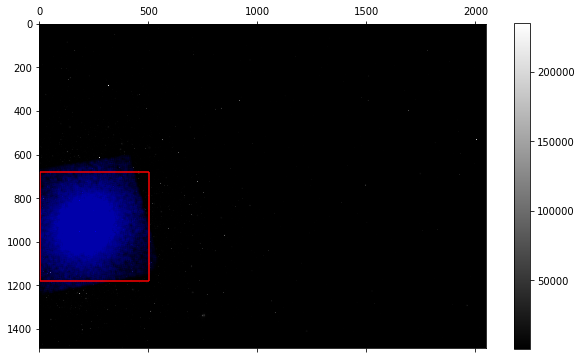

In [14]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        hubble_catalog['locs'], 
        ax,
        marker='.',
        color='b', 
        alpha = 0.01
    )

im = plotting.plot_image(ax, 
                         sdss_frame[0])

ax.hlines(x0, xmin = x1, xmax = x1 + chunk_slen, color = 'red')
ax.hlines(x0 + chunk_slen, xmin = x1, xmax = x1 + chunk_slen, color = 'red')

ax.vlines(x1, ymin = x0, ymax = x0 + chunk_slen, color = 'red')
ax.vlines(x1 + chunk_slen, ymin = x0, ymax = x0 + chunk_slen, color = 'red')

f.colorbar(im, ax = ax)

In [15]:
_daophot_locs, _daophot_fluxes = daophot_utils.load_daophot_results('./daophot_data/m2_2583.phot', 
                                                                    nelec_per_nmgy, 
                                                                    wcs, 
                                                                    slen = 100,
                                                                    x0 = 630,
                                                                    x1 = 310)

In [23]:
daophot_utils.align_daophot_locs(_daophot_locs,
                                 _daophot_fluxes,
                                 hubble_catalog['locs'],
                                 hubble_catalog['fluxes'][:, 0], 
                                 align_on_logflux = 4.5)

torch.Size([55, 2])
torch.Size([4162, 2])


(tensor([[630.1224, 360.7388],
         [630.1301, 386.8543],
         [631.0505, 375.7857],
         [631.2759, 311.8496],
         [631.3533, 380.1118],
         [631.5410, 347.8495],
         [631.6792, 342.9631],
         [632.0378, 388.5859],
         [632.1899, 408.0113],
         [632.2712, 362.7275],
         [632.6135, 319.5513],
         [632.8585, 373.3003],
         [633.1214, 339.0511],
         [633.2029, 328.5181],
         [633.5769, 385.6244],
         [633.7266, 332.3122],
         [634.6197, 349.3533],
         [635.0134, 318.5272],
         [635.1140, 404.5029],
         [635.1343, 336.4156],
         [635.6761, 320.7971],
         [637.0719, 342.1845],
         [637.5000, 359.0363],
         [637.8015, 312.0885],
         [637.8768, 402.7539],
         [637.9990, 397.6508],
         [639.0437, 362.3834],
         [639.1099, 377.2131],
         [639.2822, 372.6070],
         [639.3041, 316.1941],
         [639.5184, 348.0435],
         [639.7081, 335.7900],
        

In [22]:
hubble_catalog['fluxes']

tensor([[1101.7385, 1101.7385],
        [3339.4775, 3339.4775],
        [7721.0884, 7721.0884],
        ...,
        [3088.5154, 3088.5154],
        [1085.7998, 1085.7998],
        [1434.0021, 1434.0021]])

In [20]:
log10_hubble_fluxes = torch.log10(hubble_fluxes).squeeze()
which_hubble_brightest = torch.nonzero(log10_hubble_fluxes > align_on_logflux).squeeze()

NameError: name 'hubble_fluxes' is not defined

In [18]:
_daophot_locs.shape

torch.Size([357, 2])

In [19]:
hubble_catalog['locs'].shape

torch.Size([94296, 2])

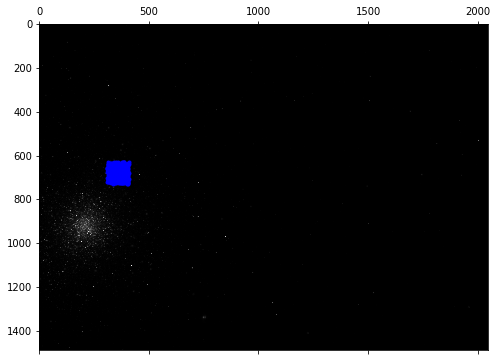

In [16]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        _daophot_locs, 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, 
                         sdss_frame[0])


In [32]:
m2_chunk = sdss_test_image = plotting.crop_image(sdss_frame, 
                                                 x0 - border_padding, 
                                                 x1 - border_padding,
                                                 chunk_slen + 2 * border_padding,
                                                 chunk_slen + 2 * border_padding)

### We focus on this chunk

In [11]:
x0 = 630
x1 = 310
chunk_slen = 100

border_padding = sleep_net.image_encoder.border_padding

In [12]:
sdss_test_image = plotting.crop_image(sdss_frame, 
                                      x0 - border_padding, 
                                      x1 - border_padding,
                                      chunk_slen + 2 * border_padding,
                                      chunk_slen + 2 * border_padding)

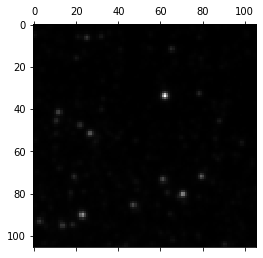

In [13]:
plt.matshow(sdss_test_image[0], 
            cmap = plt.cm.gray)

# Get starnet map estimates

In [14]:
map_estimate = sleep_net.image_encoder.map_estimate(sdss_test_image.unsqueeze(0).to(device), 
                                                    sleep_net.image_decoder.slen)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * sleep_net.image_decoder.slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

In [15]:
print(map_estimate['n_sources'])

tensor(1211.)


# Load PCAT results

In [16]:
chain_results = np.load('./fits/my_chain_nsamp3000.npz')

In [17]:
# we take the last 300 samples of the chain
pcat_n_samples = 300

In [18]:
gain = sdss_data[0]['gain'][0]

In [19]:
# n_samples x max_stars x n_bands
pcat_sampled_fluxes = chain_results['f'][:, -pcat_n_samples:, :].transpose([1, 2, 0]) * gain

# get boolean for stars that are on
pcat_is_on_sampled = pcat_sampled_fluxes[:, :, 0] > 0
assert (pcat_is_on_sampled.sum(1) == chain_results['n'][-pcat_n_samples:]).all()

# locations: n_samples x max_stars x 2
pcat_sampled_locs = np.dstack((chain_results['y'][-pcat_n_samples:, :], 
                                    chain_results['x'][-pcat_n_samples:, :])) + \
    np.array([[[630.5, 310.5]]])

# covert everything to torch tensors 
pcat_sampled_locs = torch.Tensor(pcat_sampled_locs) 
pcat_sampled_fluxes = torch.Tensor(pcat_sampled_fluxes)

pcat_samples = dict({'locs': pcat_sampled_locs, 
                     'fluxes': pcat_sampled_fluxes})

# Load DAOPHOT results

# Example subimages

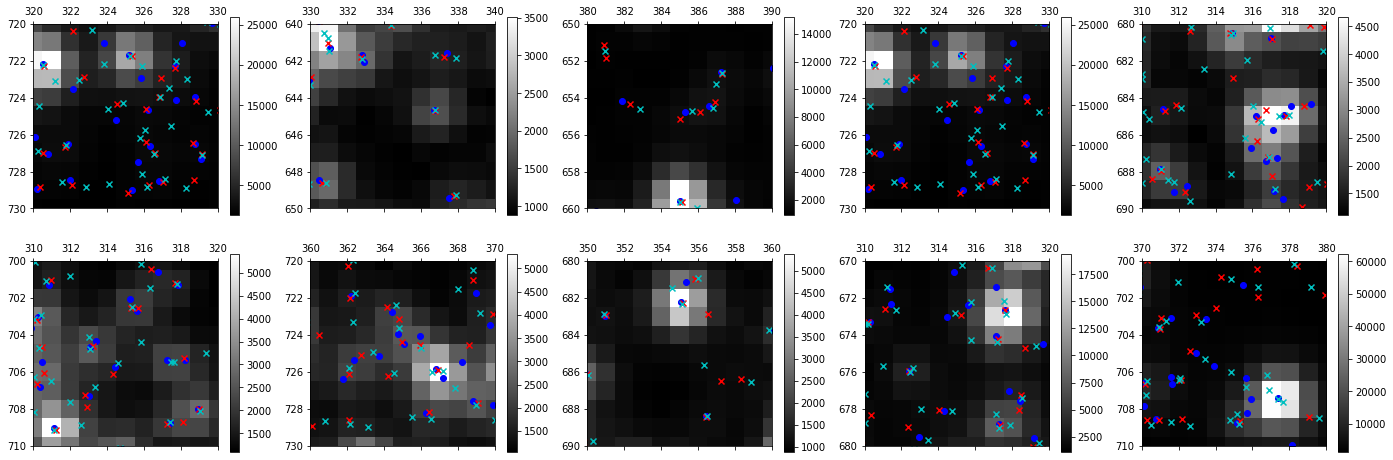

In [21]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
x0_vec = np.arange(x0, x0 + chunk_slen, subimage_slen)
x1_vec = np.arange(x1, x1 + chunk_slen, subimage_slen)

for i in range(10): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        hubble_catalog['locs'], 
        ax,
        marker='o',
        color='b',
    )
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
    plotting.plot_locations(
        pcat_samples['locs'][0], 
        ax,
        marker='x',
        color='c',
    )
    
    im = plotting.plot_image(ax, 
                             sdss_frame[0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

# Performance metrics

In [25]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

In [26]:
# the PCAT catalog has a 0.5 pixel border around the edges 
# to reproduce old PCAT results, set 
pad = 5.5
_chunk_slen = chunk_slen - 10

# pad = 0.5
# _chunk_slen = chunk_slen - 2 * pad

In [31]:
# get hubble ground truth on this chunk
hubble_test_catalog = plotting.filter_catalog_by_locs(hubble_catalog, 
                                                      x0 + pad, 
                                                      x1 + pad,
                                                      _chunk_slen,
                                                      _chunk_slen)

hubble_test_mags = utils.convert_nmgy_to_mag(hubble_test_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)

In [32]:
def get_summary_statistics(est_catalog): 
        
    est_catalog = plotting.filter_catalog_by_locs(deepcopy(est_catalog),
                                                  x0 + pad, 
                                                  x1 + pad,
                                                  _chunk_slen,
                                                  _chunk_slen)
    est_locs = est_catalog['locs']
    est_fluxes = est_catalog['fluxes'][:, 0:1]
    
    est_mags = utils.convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)

    # get tpr and ppv as function of magnitude
    tpr_vec = starnet_metrics.get_tpr_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    ppv_vec = starnet_metrics.get_ppv_vec(hubble_test_catalog['locs'],
                                          hubble_test_mags,
                                          est_locs,
                                          est_mags, 
                                          mag_bins = mag_bins)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = starnet_metrics.get_tpr_ppv(hubble_test_catalog['locs'],
                                           hubble_test_mags,
                                           est_locs,
                                           est_mags, 
                                           slack = 0.5)
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec


In [33]:
mag_bins = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

### Get results for StarNet

In [34]:
tpr, ppv, f1, starnet_tpr_vec, starnet_ppv_vec = \
    get_summary_statistics(map_estimate)

print('StarNet tpr', tpr)
print('StarNet ppv', ppv)
print('StarNet f1', f1)

StarNet tpr tensor(0.5435)
StarNet ppv tensor(0.5219)
StarNet f1 tensor(0.5325)


### Get results for PCAT

In [35]:
tpr = 0.
ppv = 0.
f1 = 0.

pcat_ppv_vec = torch.zeros(len(mag_bins) - 1)
pcat_tpr_vec = torch.zeros(len(mag_bins) - 1)

for i in range(pcat_n_samples):
    is_on = pcat_is_on_sampled[i]
    
    pcat_catalog_i = {'locs': pcat_sampled_locs[i, is_on, :], 
                      'fluxes': pcat_sampled_fluxes[i, is_on, :]}
    
    tpr_i, ppv_i, f1_i, pcat_tpr_vec, pcat_ppv_vec = \
        get_summary_statistics(pcat_catalog_i)
    
    pcat_tpr_vec += pcat_tpr_vec / pcat_n_samples
    pcat_ppv_vec += pcat_ppv_vec / pcat_n_samples
    
    tpr += tpr_i / pcat_n_samples
    ppv += ppv_i / pcat_n_samples
    f1 += f1_i / pcat_n_samples
    
print('PCAT tpr', tpr)
print('PCAT ppv', ppv)
print('PCAT f1', f1)

PCAT tpr tensor(0.5591)
PCAT ppv tensor(0.4045)
PCAT f1 tensor(0.4694)


In [19]:
from bliss.metrics import get_tpr_ppv

In [20]:
nelec_per_nmgy = 856.09845 # TODO load this somewhere

In [62]:
hubble_test_catalog = plotting.filter_catalog_by_locs(hubble_catalog, 
                                                      x0, x1, chunk_slen, chunk_slen)

In [63]:
hubble_mags = 22.5 - 2.5 * torch.log10(hubble_test_catalog['fluxes'][:, 0:1] / nelec_per_nmgy)
map_mags = 22.5 - 2.5 * torch.log10(map_estimate['fluxes'][0, :, 0:1] / nelec_per_nmgy)


tpr, ppv = starnet_metrics.get_tpr_ppv(
            hubble_test_catalog['locs'],
            hubble_mags,
            map_estimate['locs'].squeeze(0),
            map_mags,
            slack=0.5,
        )

print('True positive rate: {:.3f}'.format(tpr))
print('Positive predictive value: {:.3f}'.format(ppv))
print('F1: {:.3f}'.format(2 * tpr * ppv / (tpr + ppv)))

True positive rate: 0.556
Positive predictive value: 0.528
F1: 0.541


TODO: the stuff below still needs fixing

# Get perfomrance metrics statistics as a function of magnitude

In [25]:
from bliss.metrics import get_tpr_ppv

In [26]:
def get_tpr_vec(
    true_locs, true_mags, est_locs, est_mags, mag_bins
):

    # convert to magnitude
    tpr_vec = np.zeros(len(mag_bins) - 1)
    counts_vec = np.zeros(len(mag_bins) - 1)

    for i in range(len(mag_bins) - 1):
        which_true = (true_mags > mag_bins[i]) & (true_mags < mag_bins[i + 1])
        which_true = which_true.squeeze()
        counts_vec[i] = torch.sum(which_true)

        tpr_vec[i] = get_tpr_ppv(
            true_locs[which_true],
            true_mags[which_true],
            est_locs,
            est_mags,
            slack = 0.5
        )[0]

    return tpr_vec, mag_bins, counts_vec


def get_ppv_vec(
    true_locs, true_mags, est_locs, est_mags, mag_bins
):

    ppv_vec = np.zeros(len(mag_bins) - 1)
    counts_vec = np.zeros(len(mag_bins) - 1)

    for i in range(len(mag_bins) - 1):
        which_est = (est_mags > mag_bins[i]) & (est_mags < mag_bins[i + 1])
        which_est = which_est.squeeze()
        
        counts_vec[i] = torch.sum(which_est)
        
        ppv_vec[i] = get_tpr_ppv(
                    true_locs,
                    true_mags,
                    est_locs[which_est],
                    est_mags[which_est],
                    slack = 0.5
                )[1]
    
    return ppv_vec, mag_bins, counts_vec


In [27]:
# percentiles of the hubble magnitudes.
percentiles = np.linspace(0, 1, 11) * 100
mag_bins = np.percentile(hubble_mags.cpu(), percentiles)
        
# get tpr as function of magnitude
tpr_vec  = \
    get_tpr_vec(hubble_test_catalog['locs'],
                hubble_mags,
                map_estimate['locs'].squeeze(0),
                map_mags,
                mag_bins)[0]

# # get ppv as function of magnitude
ppv_vec  = \
    get_ppv_vec(hubble_test_catalog['locs'],
                hubble_mags,
                map_estimate['locs'].squeeze(0),
                map_mags,
                mag_bins)[0]

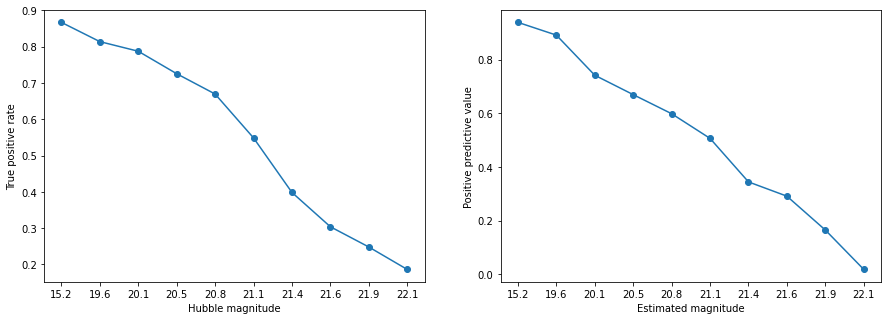

In [28]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))


# plot summary statistics as function of hubble percentile
percentiles = np.linspace(0, 1, 10 + 1) * 100
axarr[0].plot(percentiles[:-1], tpr_vec, '-o')
axarr[1].plot(percentiles[:-1], ppv_vec, '-o')

# axis labels
axarr[0].set_xlabel('Hubble magnitude')
axarr[1].set_xlabel('Estimated magnitude')
axarr[0].set_ylabel('True positive rate')
axarr[1].set_ylabel('Positive predictive value')

# replace percentiles with actual magnitudes
for i in range(2): 
    axarr[i].set_xticks(percentiles[:-1])
    axarr[i].set_xticklabels(np.round(mag_bins, 1)[:-1])


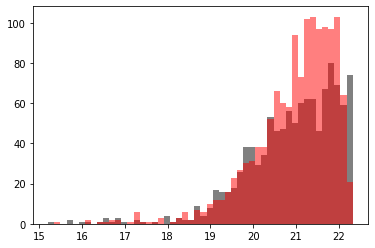

In [32]:
# flux distributions
bins = plt.hist(hubble_mags.cpu().numpy(), color = 'grey', bins = 50);
plt.hist(map_mags.cpu().numpy(), color = 'red', alpha = 0.5, bins = bins[1]);

In [ ]:
# np.savez('../../data/true_hubble_m2', 
#          sdss_image = sdss_image.cpu(), 
#          true_locs = hubble_locs.cpu(), 
#          true_fluxes = hubble_fluxes.cpu(), 
#          nelec_per_nmgy = nelec_per_nmgy)